In [1]:
%matplotlib widget 
# install https://github.com/matplotlib/ipympl
import follow_the_leader

# Anamaria's cold state: https://alog.ligo-la.caltech.edu/aLOG/index.php?callRep=69972
# Shrejit's cold state params: 
# Cao's TF modelling for HOM: https://docs.google.com/presentation/d/10y_UybWd-AvlDFVeppb_ZadiO0llSIYdXzJxIFWJr5A/edit#slide=id.p

import matplotlib.pyplot as plt
import csv
from collections import OrderedDict
from tqdm.notebook import tqdm
from copy import deepcopy

from gwpy.time import to_gps

# Copied from ftl 
import finesse
import finesse.analysis.actions as fac
import gpstime
import pickle
import argparse
import importlib
import finesse_ligo
from munch import Munch
from gwpy.timeseries import TimeSeries
import numpy as np
import os
import json
from pathlib import Path
from scipy.interpolate import interp1d
import h5py
import importlib
import importlib.resources

from follow_the_leader.sim_data import (
    SimData
)
from follow_the_leader.gwd_data import (
    llo_data
)

/Users/awjones/miniforge3/envs/llomodel/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
comparison_time = 1403893909 # Today (Jul 1st 24) last time IFO lost lock
#https://alog.ligo-la.caltech.edu/aLOG/index.php?callRep=71477
#comparison_time = to_gps('May 21 2024 23:00:00.000') # Valery's measurement is at 23:05 (time is UTC, so should match)
print(comparison_time)

max_time = 2*3600

Sim = True
if Sim: out_data = SimData(comparison_time)

if Sim: sim_data, failed = out_data.load_sim_data(verbose=False)
if Sim: simtime = sim_data['Time']

1403893909


/Users/awjones/git/ligo-commissioning-modeling/follow_the_leader/src/follow_the_leader/sim_data.py:56: UserWarning: Modifying YAML SafeDumper to allow R/W finesse material objects
  warn('Modifying YAML SafeDumper to allow R/W finesse material objects')


In [3]:
llodata = llo_data(chan_mapping='L1.yaml')

llodata.attach_ndscope_outputs(['2024_05_21-Parm.hdf5', '2024_06_01-PowerUp.hdf5'])

myPars = llodata.preprocessYAML(
    Munch.fromYAML(
        importlib.resources.read_text(
            "follow_the_leader.mapping_files", "L1.yaml"
        )
    )
)
myPars['L1:ASC-Y_TR_B_NSUM_OUTPUT'].Calibration.value = llodata.chan_mapping['L1:ASC-Y_TR_B_NSUM_OUTPUT'].Calibration.value *3/2
myPars['L1:ASC-X_TR_B_NSUM_OUTPUT'].Calibration.value = llodata.chan_mapping['L1:ASC-X_TR_B_NSUM_OUTPUT'].Calibration.value *3/2

llodata.update_mapping(myPars)

file found.
Top level keys:['1400367618', '1403893909']
Top level attrs:{'created': 1406324654.068813}
auxillary file 2024_05_21-Parm.hdf5, found.
Top level keys:['L1:ASC-X_TR_A_NSUM_OUTPUT', 'L1:ASC-Y_TR_A_NSUM_OUTPUT', 'L1:GRD-ISC_LOCK_STATE_N', 'L1:IMC-IM4_TRANS_SUM_OUTPUT', 'L1:LSC-PRC_GAIN_MON']
Top level attrs:{'t0': 1400367618.0, 'window': array([   0., 3600.])}
auxillary file 2024_06_01-PowerUp.hdf5, found.
Top level keys:['L1:ASC-X_TR_A_NSUM_OUTPUT', 'L1:ASC-Y_TR_A_NSUM_OUTPUT', 'L1:GRD-ISC_LOCK_STATE_N', 'L1:IMC-IM4_TRANS_SUM_OUTPUT', 'L1:LSC-PRC_GAIN_MON']
Top level attrs:{'t0': 1403893909.0, 'window': array([   0., 7200.])}


/var/folders/48/ndr53b7n5r36gv5n62vtdp6c0000gp/T/ipykernel_26485/3073159982.py:7: DeprecationWarning: read_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  importlib.resources.read_text(


Timespan matched to 2024_06_01-PowerUp.hdf5
Data & timespan matched to 2024_06_01-PowerUp.hdf5
Looks like low-passed data, trying mean
Timespan matched to 2024_06_01-PowerUp.hdf5
channel L1:ASC-X_TR_B_NSUM_OUTPUT not found in 2024_06_01-PowerUp.hdf5
Timespan matched to 2024_06_01-PowerUp.hdf5
channel L1:ASC-Y_TR_B_NSUM_OUTPUT not found in 2024_06_01-PowerUp.hdf5
Timespan matched to 2024_06_01-PowerUp.hdf5
Data & timespan matched to 2024_06_01-PowerUp.hdf5
Looks like low-passed data, trying mean
Timespan matched to 2024_06_01-PowerUp.hdf5
Data & timespan matched to 2024_06_01-PowerUp.hdf5
Looks like low-passed data, trying mean


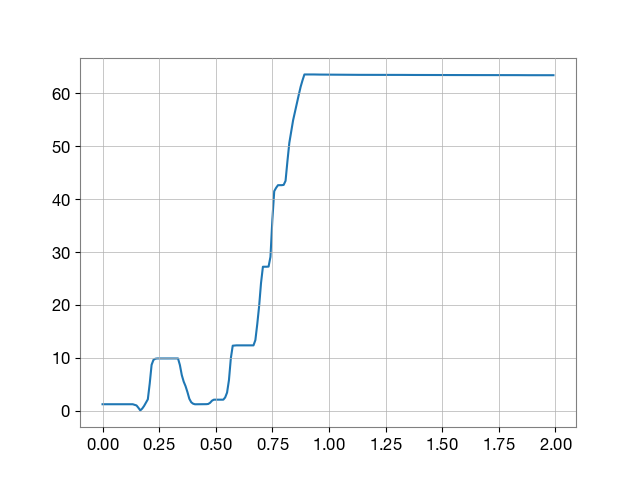

In [4]:
Pin = llodata.get_timeseries(comparison_time, 'Pin', max_time, interpolate=True, frametype='L1_T', verbose=True, pad=0)
Px, Px_t = llodata.get_timeseries(comparison_time, 'Px', max_time, interpolate=False, frametype='L1_T', verbose=True, pad=0)
Py, Py_t = llodata.get_timeseries(comparison_time, 'Py', max_time, interpolate=False, frametype='L1_T', verbose=True, pad=0)
PRG, PRG_t = llodata.get_timeseries(comparison_time, 'PRG', max_time, interpolate=False, frametype='L1_T', verbose=True, pad=0)
G, G_t = llodata.get_timeseries(comparison_time, 'Guard', max_time, interpolate=False, verbose=True, pad=0)
Pin_t = np.arange(0,max_time,30)
plt.plot(Pin_t/3600, Pin(Pin_t))

Text(0, 0.5, 'Guard State [num]')

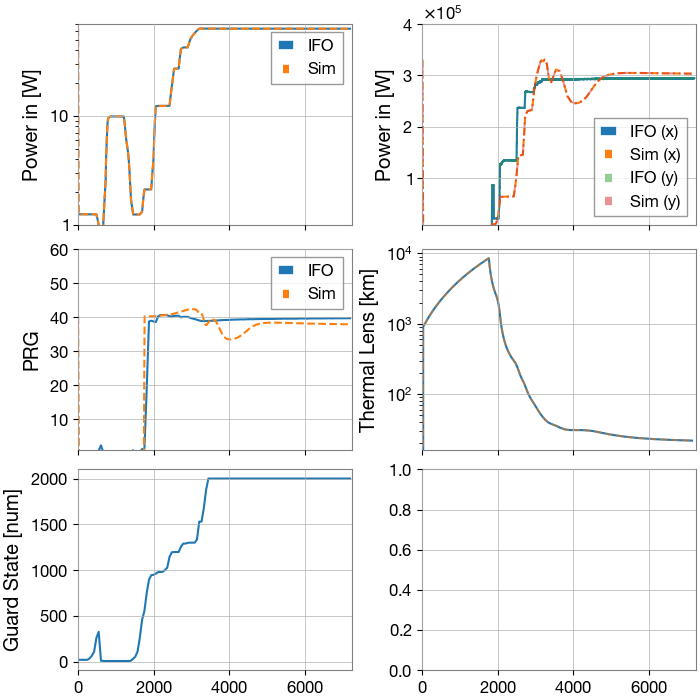

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, 
                       squeeze=False, layout="constrained",
                      figsize=(7,7))
ax[0][0].semilogy(Px_t, Pin(Px_t), label='IFO', ls='-')
if Sim: ax[0][0].semilogy(simtime, np.array(sim_data['Pin']), label='Sim', ls='--')
ax[0][0].set_ylim([1e0,70])
ax[0][0].legend()
ax[0][0].set_ylabel('Power in [W]')

ax[1][0].semilogy(PRG_t, PRG, label='IFO', ls='-')
if Sim: ax[1][0].semilogy(simtime, np.array(sim_data['PRG']), label='Sim', ls='--')
ax[1][0].set_ylim([1e0,60])
ax[1][0].legend()
ax[1][0].set_ylabel('PRG')
ax[1][0].set_yscale('linear')

if Sim: ax[1][0].set_xlim([0,simtime[-1]+100])

ax[0][1].semilogy(Px_t, Px, label='IFO (x)', ls='-')
if Sim: ax[0][1].semilogy(simtime, np.array(sim_data['Px']), label='Sim (x)', ls='--')

ax[0][1].semilogy(Px_t, Px, label='IFO (y)', ls=':', alpha=0.5)
if Sim: ax[0][1].semilogy(simtime, np.array(sim_data['Px']), label='Sim (y)', ls='-.',alpha=0.5)

ax[0][1].set_ylim([1e4,400e3])
ax[0][1].set_yscale('linear')
ax[0][1].legend()
ax[0][1].set_ylabel('Power in [W]')

if Sim: ax[1][1].semilogy(np.array(simtime), 1e-3*np.array(sim_data['fx']), label='Sim (x)', ls='-')
if Sim: ax[1][1].semilogy(np.array(simtime), 1e-3*np.array(sim_data['fx']), label='Sim (y)', ls='--',alpha=0.5)
ax[1][1].set_ylabel('Thermal Lens [km]')
ax[0][1].legend()

ax[2][0].plot(G_t, G)
ax[2][0].set_ylabel('Guard State [num]')